In [1]:
# libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import findspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t

from pyspark.sql.types import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pyspark
from pyspark import SparkContext
sc = SparkContext()

In [3]:
# builds spark session
spark = SparkSession.builder.master('local').appName('Spark Builder').getOrCreate()

In [4]:
# Because I was unable to establish a connection with BigQuery, I decided to upload an aggregated file instead
dh_test = spark.read.csv('dh-results.csv', 
                          header=True, nullValue='unknown', mode='Overwrite',
                          inferSchema=True, sep=','
                         )

## <span style="ff0000">1. Sessions per Hour of the Day</span>

In [5]:
sessionsViz = (dh_test
               .withColumn("hour_of_day", f.hour(f.col('yyyy_mm_dd')))
               .withColumn('week_nr', f.weekofyear(f.col('yyyy_mm_dd')))                
               .groupBy('week_nr','hour_of_day')
               .agg(f.countDistinct('visitID').alias('nr_sessions'))
               .orderBy(f.asc('week_nr'),f.asc('hour_of_day'))
              ).toPandas()

sessionsViz.head()

,week_nr,hour_of_day,nr_sessions
0,9,0,4264
1,9,1,3610
2,9,2,2966
3,9,3,2212
4,9,4,1661


<AxesSubplot:xlabel='hour_of_day', ylabel='nr_sessions'>

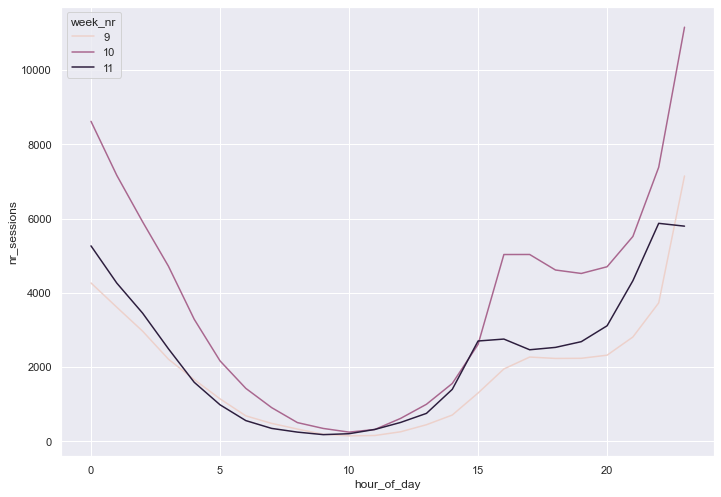

In [6]:
from scipy import stats

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(data=sessionsViz, x="hour_of_day", y="nr_sessions", hue='week_nr')

## <span style="ff0000">2. Peak Hour for Sessions with Transactions</span>
**ANSWER:** 23 h

In [7]:
sessionsTran = (dh_test
                .withColumn("hour_of_day", f.hour(f.col('yyyy_mm_dd')))              
                .groupBy('has_transaction','hour_of_day')
                .agg(f.countDistinct('visitID').alias('nr_sessions'))
                .orderBy(f.asc('hour_of_day'))
              ).toPandas()

sessionsTran.head()

,has_transaction,hour_of_day,nr_sessions
0,1,0,5066
1,0,0,14451
2,1,1,3715
3,0,1,12201
4,1,2,2743


<AxesSubplot:xlabel='hour_of_day', ylabel='nr_sessions'>

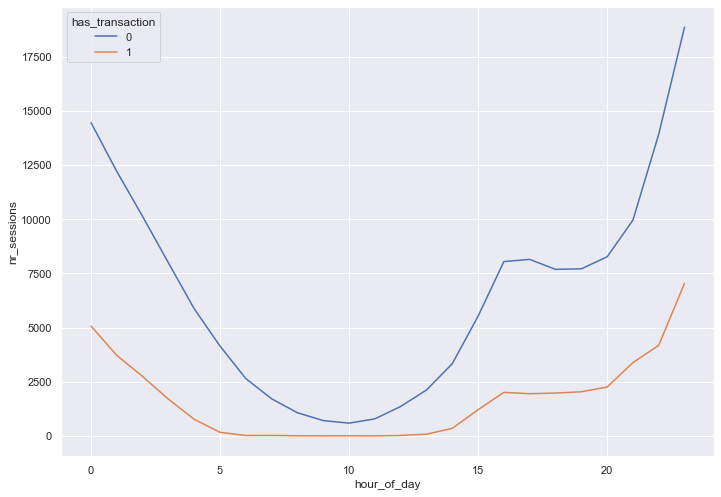

In [8]:
sns.lineplot(data=sessionsTran, x="hour_of_day", y="nr_sessions", hue='has_transaction')

## <span style="ff0000">3. Time Spent on Platform Distribution (in seconds) </span>

In [9]:
timeSpent = (dh_test              
             .groupBy('fullvisitorID')
             .agg(f.round(f.sum('time_spent_ss'),0).alias('total_time_spent_ss'))
             .where(f.col('total_time_spent_ss') > 0)
              ).toPandas()

timeSpent.head()

,fullvisitorID,total_time_spent_ss
0,6710864057167421609,1748
1,17834276064431503181,6293
2,14866602776066205241,2844
3,3842292253313693116,1280
4,4814854891275772066,2898


In [10]:
timeSpent.describe()

,total_time_spent_ss
count,97993.000000
mean,1473.685120
std,2718.188618
min,1.000000
25%,44.000000
50%,312.000000
75%,1876.000000
max,71028.000000


Text(0, 0.5, 'Frequency - nr_users')

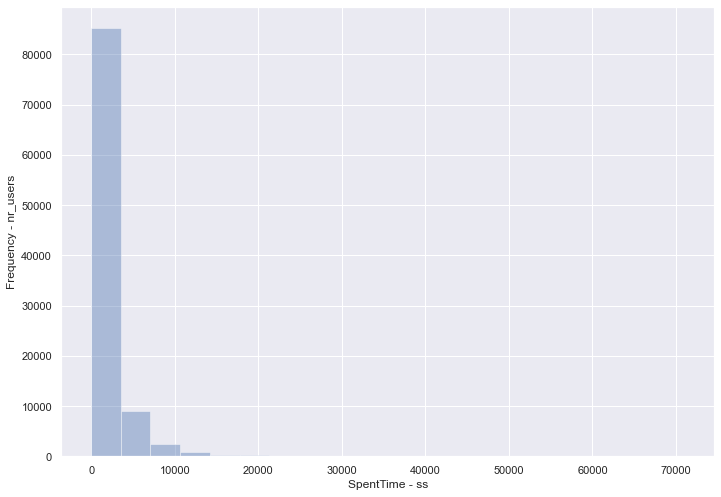

In [11]:
sns.distplot(timeSpent['total_time_spent_ss'], bins=20, kde=False)
plt.xlabel('SpentTime - ss', fontsize=12)
plt.ylabel('Frequency - nr_users', fontsize=12)

In [12]:
## function to quickly convert seconds to time format
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%02d:%02d:%02d" % (hour, minutes, seconds)

convert_udf = f.udf(convert, t.StringType())

In [13]:
convert(125)

'00:02:05'

## <span style="ff0000">4. Function to Extract String and Return Integer in Seconds </span>

In [14]:
def get_length(raw_str):
    import json
    parsed_str = json.loads(raw_str)
    try:
        time = str(parsed_str['event_arguments']['time'])
        return time
    except:
        return 'NA'
    
get_length_udf = f.udf(get_length, t.StringType())

In [15]:
raw_str = '''{"visitorId": "2312979", "event_arguments": {"lang": "es", "time": 19586740361, "visitorId": 12979}, "event_type": "order_confirmation.loaded"}'''

In [16]:
round((int(get_length(raw_str))/1000),0)

19586740.0